### Reading Libraries

In [1]:
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE,RFECV
from sklearn.preprocessing import RobustScaler
from sklearn.utils import resample
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LassoCV
from sklearn.metrics import confusion_matrix, accuracy_score,recall_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report,roc_auc_score,roc_curve
import warnings
warnings.filterwarnings('ignore')

Using TensorFlow backend.


### Reading Data and Dropping "duration"

In [2]:
data = pd.read_csv('TRAIN DATA')
data.drop(columns = 'duration',inplace = True)

### Data Preparation

In [3]:
def age(dataframe):
    dataframe.loc[dataframe['age'] <= 33, 'age'] = 1
    dataframe.loc[(dataframe['age'] > 33) & (dataframe['age'] <= 48), 'age'] = 2
    dataframe.loc[(dataframe['age'] > 48) & (dataframe['age'] <= 71), 'age'] = 3
    dataframe.loc[(dataframe['age'] > 71) & (dataframe['age'] <= 95), 'age'] = 4
           
    return dataframe

age(data);

In [4]:
## Label encoding for both the dataframes
labelencoder_X = LabelEncoder()

In [5]:
def encoding(dataframe):
    dataframe['job'] = labelencoder_X.fit_transform(dataframe.job)
    jobs_key = pd.DataFrame(list(zip(list(labelencoder_X.classes_),
                                 list(np.arange(0,len(list(labelencoder_X.classes_)),1)))), columns = ['jobs','label'])
    
    dataframe['marital'] = labelencoder_X.fit_transform(dataframe.marital)
    marital_key = pd.DataFrame(list(zip(list(labelencoder_X.classes_),
                                 list(np.arange(0,len(list(labelencoder_X.classes_)),1)))), columns = ['marital','label'])
    
    dataframe['education'] = labelencoder_X.fit_transform(dataframe.education)
    education_key = pd.DataFrame(list(zip(list(labelencoder_X.classes_),
                                 list(np.arange(0,len(list(labelencoder_X.classes_)),1)))), columns = ['education','label'])
    
    dataframe['connect'] = labelencoder_X.fit_transform(dataframe.connect)
    connect_key = pd.DataFrame(list(zip(list(labelencoder_X.classes_),
                                 list(np.arange(0,len(list(labelencoder_X.classes_)),1)))), columns = ['connect','label'])
    
    dataframe['landline'] = labelencoder_X.fit_transform(dataframe.landline)
    landline_key = pd.DataFrame(list(zip(list(labelencoder_X.classes_),
                                 list(np.arange(0,len(list(labelencoder_X.classes_)),1)))), columns = ['landline','label'])
    
    dataframe['smart'] = labelencoder_X.fit_transform(dataframe.smart)
    smart_key = pd.DataFrame(list(zip(list(labelencoder_X.classes_),
                                 list(np.arange(0,len(list(labelencoder_X.classes_)),1)))), columns = ['smart','label'])
    
    dataframe['last_month'] = labelencoder_X.fit_transform(dataframe.last_month)
    month_key = pd.DataFrame(list(zip(list(labelencoder_X.classes_),
                                 list(np.arange(0,len(list(labelencoder_X.classes_)),1)))), columns = ['month','label'])
    
    return dataframe

In [6]:
encoding(data)

,age,job,marital,education,connect,balance,landline,smart,last_day,last_month,campaign,passdays,previous,poutcome,target
0,3,4,1,2,0,2143,1,0,5,8,1,-1,0,unknown,0
1,2,9,2,1,0,29,1,0,5,8,1,-1,0,unknown,0
2,1,2,1,1,0,2,1,1,5,8,1,-1,0,unknown,0
3,3,5,1,0,0,229,1,0,5,8,1,-1,0,unknown,0
4,3,1,1,0,0,52,1,0,5,8,1,-1,0,unknown,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40503,1,9,2,1,0,505,0,1,17,9,2,-1,0,unknown,1
40504,3,9,1,2,0,825,0,0,17,9,3,-1,0,unknown,1
40505,4,5,1,1,0,5715,0,0,17,9,5,184,3,success,1
40506,3,1,1,1,0,668,0,0,17,9,4,-1,0,unknown,0


In [7]:
# Splitting into fresh and repeated targets
fresh_targets = data[data.previous == 0]
repeated_targets = data[data.previous != 0]

In [8]:
# Eliminating "unknown" rows in repeated targets
repeated_targets = repeated_targets[repeated_targets.poutcome != 'unknown']

In [9]:
fresh_targets.drop(columns = ["previous","poutcome","passdays"], inplace = True)

In [10]:
# Subtracting one from the each value of campaign
repeated_targets['campaign'] = repeated_targets['campaign'] - 1

In [11]:
# Label encoding the poutcome column of repeated targets which have three labels - success, failure, other
repeated_targets['poutcome'] = labelencoder_X.fit_transform(repeated_targets.poutcome)
outcome_key = pd.DataFrame(list(zip(list(labelencoder_X.classes_),
                                 list(np.arange(0,len(list(labelencoder_X.classes_)),1)))), columns = ['outcome','label'])

In [12]:
fresh_targets['campaign'] = fresh_targets['campaign'] - 1

In [13]:
repeated_targets.reset_index(inplace = True)
repeated_targets.drop(columns = 'index', inplace = True)

#### Correlation Matrix to eliminate highly correlated data

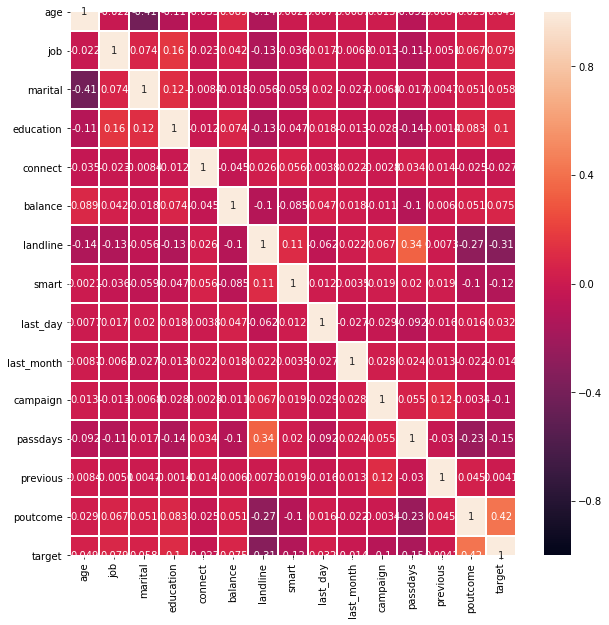

In [14]:
plt.subplots(figsize = (10,10))
repeated_targets_corr = repeated_targets.corr()
repeated_targets_corr[np.abs(repeated_targets_corr)>.65] = 1
sns.heatmap(repeated_targets_corr, annot = True, vmin = -1, vmax = 1, linewidths=1)

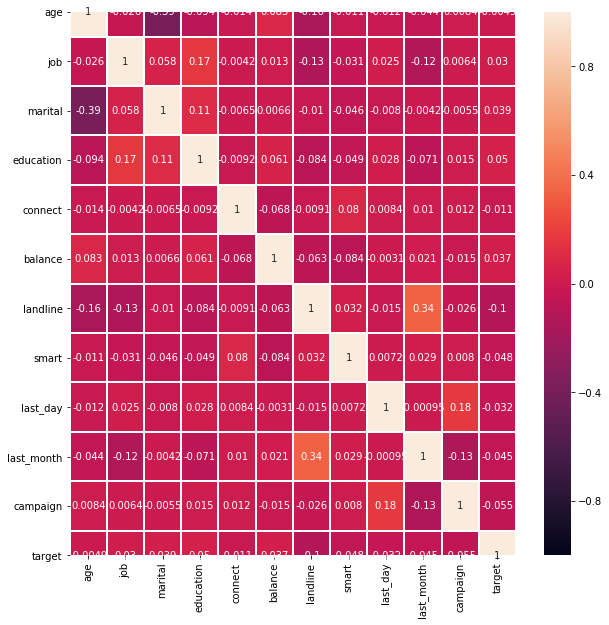

In [15]:
plt.subplots(figsize = (10,10))
fresh_targets_corr = fresh_targets.corr()
fresh_targets_corr[np.abs(fresh_targets_corr)>.65] = 1
sns.heatmap(fresh_targets_corr, annot = True, vmin = -1, vmax = 1, linewidths=1)

##### No variables which are highly correlated with one another, so not dropping any

In [16]:
# repeated targets dataframe
rX = repeated_targets.drop(columns = 'target')
cols1 = list(rX)
rY = pd.DataFrame(repeated_targets['target'])

In [17]:
# fresh target dataframe
fX = fresh_targets.drop(columns = 'target')
cols2 = list(fX)
fY = pd.DataFrame(fresh_targets['target'])

## Distance based methods approach
1. Logistic Regression - CHECKED

#### SMOTE for tackling class imbalance, and then using feature selection method

In [18]:
sc = StandardScaler()

In [19]:
smt = SMOTE()

In [20]:
rX1, rY1 = smt.fit_sample(rX, rY)
rX1 = pd.DataFrame(rX1, columns = cols1)
rY1 = pd.DataFrame(rY1, columns = ['target'])

In [21]:
fX1, fY1 = smt.fit_sample(fX, fY)
fX1 = pd.DataFrame(fX1, columns = cols2)
fY1 = pd.DataFrame(fY1, columns = ['target'])

In [22]:
rXtr, rXte, rYtr, rYte = train_test_split(rX1, rY1, stratify=rY1, test_size=0.25, random_state = 42)

In [23]:
fXtr, fXte, fYtr, fYte = train_test_split(fX1, fY1, stratify=fY1, test_size=0.25, random_state = 42)

In [24]:
rXtr.shape, rXte.shape

((8551, 14), (2851, 14))

In [25]:
# Logistic Regression - REPEATED TARGETS
estimator = LogisticRegression(penalty='l1', class_weight='balanced', solver = 'liblinear')
selector = RFE(estimator, 5, step=1)
selector = selector.fit(rXtr, rYtr)
logpred = selector.predict(rXte)
print(classification_report(rYte,logpred))
print(confusion_matrix(rYte,logpred))

              precision    recall  f1-score   support

           0       0.80      0.72      0.76      1426
           1       0.75      0.82      0.78      1425

    accuracy                           0.77      2851
   macro avg       0.77      0.77      0.77      2851
weighted avg       0.77      0.77      0.77      2851

[[1028  398]
 [ 262 1163]]


In [26]:
repeated_ranking = pd.DataFrame(list(zip(rXtr.columns,selector.ranking_)),columns = ['column_name','ranking'])
repeated_ranking.sort_values(by = 'ranking').head()

,column_name,ranking
2,marital,1
4,connect,1
6,landline,1
7,smart,1
13,poutcome,1


In [27]:
# Logistic Regression - FRESH TARGETS
estimator = LogisticRegression(penalty='l1', class_weight='balanced', solver = 'liblinear')
selector = RFE(estimator, 5, step=1)
selector = selector.fit(fXtr, fYtr)
logpred = selector.predict(fXte)
print(classification_report(fYte,logpred))
print(confusion_matrix(fYte,logpred))

              precision    recall  f1-score   support

           0       0.74      0.76      0.75      7528
           1       0.75      0.73      0.74      7528

    accuracy                           0.74     15056
   macro avg       0.74      0.74      0.74     15056
weighted avg       0.74      0.74      0.74     15056

[[5723 1805]
 [2046 5482]]


In [28]:
fresh_ranking = pd.DataFrame(list(zip(fXtr.columns,selector.ranking_)),columns = ['column_name','ranking'])
fresh_ranking.sort_values(by = 'ranking').head()

,column_name,ranking
0,age,1
2,marital,1
4,connect,1
6,landline,1
7,smart,1


#### We observe that marital status is more important when customers are targeted for the first time, unlike repeated targets where the PREVIOUS outcome of the past campaigns play a very important role

## Tree based methods approach
1. Decision Trees - CHECKED
2. Random Forests - CHECKED

### Approach - without using sampling techniques

In [29]:
rXtr, rXte, rYtr, rYte = train_test_split(rX, rY, stratify=rY, test_size=0.25, random_state = 42)
fXtr, fXte, fYtr, fYte = train_test_split(fX, fY, stratify=fY, test_size=0.25, random_state = 42)

In [30]:
dtree = DecisionTreeClassifier(criterion='gini', class_weight={0:1,1:9}) #criterion = entopy, gini
dtree.fit(rXtr, rYtr)
dpred = dtree.predict(rXte)
print(confusion_matrix(rYte, dpred))
print(classification_report(rYte,dpred))

[[1215  211]
 [ 231  196]]
              precision    recall  f1-score   support

           0       0.84      0.85      0.85      1426
           1       0.48      0.46      0.47       427

    accuracy                           0.76      1853
   macro avg       0.66      0.66      0.66      1853
weighted avg       0.76      0.76      0.76      1853



In [31]:
dtree = DecisionTreeClassifier(criterion='gini', class_weight={0:1,1:9}) #criterion = entopy, gini
dtree.fit(fXtr, fYtr)
dpred = dtree.predict(fXte)
print(confusion_matrix(fYte, dpred))
print(classification_report(fYte,dpred))

[[6933  595]
 [ 624  122]]
              precision    recall  f1-score   support

           0       0.92      0.92      0.92      7528
           1       0.17      0.16      0.17       746

    accuracy                           0.85      8274
   macro avg       0.54      0.54      0.54      8274
weighted avg       0.85      0.85      0.85      8274



##### We see that without using data preparation techniques, the recall of the test set is very low. Accuracy is not the main concern, when the recall itself is low. Hence, we first needed to focus on increasing recall by using over and under sampling TOGETHER and then focus on precision by altering and hypertuning the parameters.

### Approach - using over and under sampling at the same time

In [32]:
ffull = pd.concat([fX,fY], axis = 1)
rfull = pd.concat([rX,rY], axis = 1)

In [33]:
fY0 = ffull[ffull.target == 0]
fY1 = ffull[ffull.target == 1]
rY0 = rfull[rfull.target == 0]
rY1 = rfull[rfull.target == 1]

In [34]:
# downsampling of 0
fdownsampled = resample(fY0, replace = False, # sample without replacement,
                       n_samples = 12000, # match minority n
                                random_state = 27) # reproducible results

rdownsampled = resample(rY0, replace = False, # sample without replacement,
                       n_samples = 3500, # match minority n
                                random_state = 27) # reproducible results

In [35]:
# upsampling of 1
fupsampled = resample(fY1, replace = True, # sample without replacement,
                       n_samples = 12000, # match minority n
                                random_state = 27) # reproducible results

rupsampled = resample(rY1, replace = True, # sample without replacement,
                       n_samples = 3500, # match minority n
                                random_state = 27) # reproducible results

In [36]:
ffull = pd.concat([fdownsampled, fupsampled], axis = 0)
ffull.target.value_counts()

1    12000
0    12000
Name: target, dtype: int64

In [37]:
rfull = pd.concat([rdownsampled, rupsampled], axis = 0)
rfull.target.value_counts()

1    3500
0    3500
Name: target, dtype: int64

In [38]:
xffull = ffull.drop(columns = 'target')
yffull = ffull['target']

xrfull = rfull.drop(columns = 'target')
yrfull = rfull['target']

In [39]:
xftr, xfte, yftr, yfte = train_test_split(xffull, yffull,test_size=0.25, random_state = 42, stratify = yffull)

In [40]:
xrtr, xrte, yrtr, yrte = train_test_split(xrfull, yrfull,test_size=0.25, random_state = 42, stratify = yrfull)

In [41]:
dtree = DecisionTreeClassifier(criterion='gini') #criterion = entopy, gini
dtree.fit(xftr, yftr)
dpred = dtree.predict(xfte)
print(classification_report(yfte,dpred))
print(confusion_matrix(yfte, dpred))

              precision    recall  f1-score   support

           0       0.96      0.79      0.87      3000
           1       0.82      0.97      0.89      3000

    accuracy                           0.88      6000
   macro avg       0.89      0.88      0.88      6000
weighted avg       0.89      0.88      0.88      6000

[[2363  637]
 [  96 2904]]


In [42]:
dtree = DecisionTreeClassifier(criterion='gini') #criterion = entopy, gini
dtree.fit(xrtr, yrtr)
dpred = dtree.predict(xrte)
print(classification_report(yrte,dpred))
print(confusion_matrix(yrte, dpred))

              precision    recall  f1-score   support

           0       0.91      0.77      0.83       875
           1       0.80      0.92      0.86       875

    accuracy                           0.85      1750
   macro avg       0.85      0.85      0.84      1750
weighted avg       0.85      0.85      0.84      1750

[[672 203]
 [ 67 808]]


In [43]:
##RANDOM FOREST CLASSIFIER      #R

In [45]:
rfc = RandomForestClassifier()
rfc.fit(xftr,yftr)
rfcfpred = rfc.predict(xfte)
params = {'n_estimators':np.arange(50,200,50),
        'max_depth': [80, 90, 100, 110],
        'max_features': [3, 4],
        'criterion':['gini','entropy']}
fgrid_search = GridSearchCV(estimator = rfc, param_grid = params, cv = 3)
fgrid_search.fit(xftr, yftr)
fgridpred = fgrid_search.predict(xfte)
print("BASE ESTIMATOR")
print(classification_report(yfte,rfcfpred))
print(confusion_matrix(yfte, rfcfpred))
print("GRID SEARCH ESTIMATOR")
print(classification_report(yfte,fgridpred))
print(confusion_matrix(yfte, fgridpred))

BASE ESTIMATOR
              precision    recall  f1-score   support

           0       0.94      0.90      0.92      3000
           1       0.90      0.95      0.92      3000

    accuracy                           0.92      6000
   macro avg       0.92      0.92      0.92      6000
weighted avg       0.92      0.92      0.92      6000

[[2689  311]
 [ 163 2837]]
GRID SEARCH ESTIMATOR
              precision    recall  f1-score   support

           0       0.96      0.91      0.93      3000
           1       0.91      0.97      0.94      3000

    accuracy                           0.94      6000
   macro avg       0.94      0.94      0.94      6000
weighted avg       0.94      0.94      0.94      6000

[[2717  283]
 [ 103 2897]]


In [46]:
rfc = RandomForestClassifier()
rfc.fit(xrtr,yrtr)
rfcrpred = rfc.predict(xrte)
params = {'n_estimators':np.arange(50,200,50),
        'max_depth': [80, 90, 100, 110],
        'max_features': [3, 4],
        'criterion':['gini','entropy']}
rgrid_search = GridSearchCV(estimator = rfc, param_grid = params, cv = 3)
rgrid_search.fit(xrtr, yrtr)
rgridpred = rgrid_search.predict(xrte)
print("BASE ESTIMATOR")
print(classification_report(yrte,rfcrpred))
print(confusion_matrix(yrte, rfcrpred))
print('\n')
print("GRID SEARCH ESTIMATOR")
print(classification_report(yrte, rgridpred))
print(confusion_matrix(yrte, rgridpred))

BASE ESTIMATOR
              precision    recall  f1-score   support

           0       0.90      0.86      0.88       875
           1       0.86      0.91      0.88       875

    accuracy                           0.88      1750
   macro avg       0.88      0.88      0.88      1750
weighted avg       0.88      0.88      0.88      1750

[[751 124]
 [ 83 792]]


GRID SEARCH ESTIMATOR
              precision    recall  f1-score   support

           0       0.93      0.84      0.88       875
           1       0.86      0.94      0.89       875

    accuracy                           0.89      1750
   macro avg       0.89      0.89      0.89      1750
weighted avg       0.89      0.89      0.89      1750

[[737 138]
 [ 55 820]]


In [47]:
fgrid_search.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=110, max_features=3, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=150,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [48]:
rgrid_search.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=90, max_features=3, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=50,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [ ]:
##PREPARING VALIDATION DATA   #R

In [51]:
df = pd.read_csv('TEST DATA')
df.drop(columns = 'duration',inplace = True)
age(df)
encoding(df)

,age,job,marital,education,connect,balance,landline,smart,last_day,last_month,campaign,passdays,previous,poutcome,target
0,1,10,1,0,0,1787,0,0,19,10,1,-1,0,unknown,0
1,1,7,1,1,0,4789,1,1,11,8,1,339,4,failure,0
2,2,4,2,2,0,1350,1,0,16,0,1,330,1,failure,0
3,1,4,1,2,0,1476,1,1,3,6,4,-1,0,unknown,0
4,3,1,1,1,0,0,1,0,5,8,1,-1,0,unknown,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4516,1,7,1,1,0,-333,1,0,30,5,5,-1,0,unknown,0
4517,3,6,1,2,1,-3313,1,1,9,8,1,-1,0,unknown,0
4518,3,9,1,1,0,295,0,0,19,1,11,-1,0,unknown,0
4519,1,1,1,1,0,1137,0,0,6,3,4,211,3,other,0


In [52]:
fresh_test = df[df.previous == 0]
repeated_test = df[df.previous != 0]

fresh_test.drop(columns = ["previous","poutcome","passdays"], inplace = True)

repeated_test['campaign'] = repeated_test['campaign'] - 1
repeated_test['poutcome'] = labelencoder_X.fit_transform(repeated_test.poutcome)
outcome_key = pd.DataFrame(list(zip(list(labelencoder_X.classes_),
                                 list(np.arange(0,len(list(labelencoder_X.classes_)),1)))), columns = ['outcome','label'])

fresh_test['campaign'] = fresh_test['campaign'] - 1

rtestX = repeated_test.drop(columns = 'target')
cols1 = list(rtestX)
rtestY = repeated_test['target']

ftestX = fresh_test.drop(columns = 'target')
cols2 = list(ftestX)
ftestY = fresh_test['target']

In [ ]:
##PREDICTING ON VALIDATION DATA

In [54]:
rpred = rgrid_search.predict(rtestX)
print(confusion_matrix(rtestY, rpred))
print(round(accuracy_score(rtestY, rpred),2)*100)
print(classification_report(rtestY, rpred))

[[582  50]
 [ 18 166]]
92.0
              precision    recall  f1-score   support

           0       0.97      0.92      0.94       632
           1       0.77      0.90      0.83       184

    accuracy                           0.92       816
   macro avg       0.87      0.91      0.89       816
weighted avg       0.92      0.92      0.92       816



In [55]:
fpred = fgrid_search.predict(ftestX)
print(confusion_matrix(ftestY, fpred))
print(round(accuracy_score(ftestY, fpred),2)*100)
print(classification_report(ftestY, fpred))

[[3135  233]
 [  31  306]]
93.0
              precision    recall  f1-score   support

           0       0.99      0.93      0.96      3368
           1       0.57      0.91      0.70       337

    accuracy                           0.93      3705
   macro avg       0.78      0.92      0.83      3705
weighted avg       0.95      0.93      0.94      3705

